In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

ROOT = Path(r"C:\DOCTORAL HUB\nmr_pipeline_project")

# Load latest enhanced dataset
data_path = ROOT / "data/merged/merged_phase3_enhanced_with_atomctx.csv"
df = pd.read_csv(data_path)
print(" Loaded:", data_path, " | Rows:", len(df))


 Loaded: C:\DOCTORAL HUB\nmr_pipeline_project\data\merged\merged_phase3_enhanced_with_atomctx.csv  | Rows: 426348


In [2]:
# Drop non-numeric or identifier columns
ban_cols = ["mol_idx","atom_index","element_x","element_y",
            "shift_ppm_x","shift_ppm_y"]
num_cols = [c for c in df.columns if c not in ban_cols and np.issubdtype(df[c].dtype, np.number)]

# Clean NaN / inf
df[num_cols] = df[num_cols].replace([np.inf,-np.inf], np.nan).fillna(0)
print("Numeric feature count:", len(num_cols))


Numeric feature count: 146


In [3]:
def train_and_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2  = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    return r2, rmse, mae


In [4]:
elements = sorted(df["element_y"].dropna().unique())
results = []

for elem in elements:
    sub = df[df["element_y"]==elem].copy()
    if len(sub) < 100:
        print(f"Skipping {elem} (too few samples: {len(sub)})")
        continue

    X = sub[num_cols].values
    y = sub["shift_ppm_y"].values
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

    # Random Forest
    rf = RandomForestRegressor(
        n_estimators=300,max_depth=10,min_samples_split=2,
        random_state=42,n_jobs=-1)
    r2,rmse,mae = train_and_eval(rf,X_train,X_test,y_train,y_test)
    results.append({"Element":elem,"Model":"RandomForest","R2":r2,"RMSE":rmse,"MAE":mae})

    # XGBoost
    xgb = XGBRegressor(
        n_estimators=500,learning_rate=0.05,max_depth=8,
        subsample=0.8,colsample_bytree=0.8,
        random_state=42,n_jobs=-1)
    r2,rmse,mae = train_and_eval(xgb,X_train,X_test,y_train,y_test)
    results.append({"Element":elem,"Model":"XGBoost","R2":r2,"RMSE":rmse,"MAE":mae})

    print(f"{elem}:  RF R²={results[-2]['R2']:.3f} | XGB R²={results[-1]['R2']:.3f}")


B:  RF R²=0.546 | XGB R²=0.531
C:  RF R²=0.346 | XGB R²=0.357
Skipping Cl (too few samples: 1)
F:  RF R²=0.075 | XGB R²=0.047
Skipping Ge (too few samples: 3)
H:  RF R²=-0.164 | XGB R²=-0.531
Skipping K (too few samples: 1)
N:  RF R²=0.260 | XGB R²=0.145
O:  RF R²=0.095 | XGB R²=-0.304
P:  RF R²=0.449 | XGB R²=0.475
Skipping S (too few samples: 18)
Skipping Si (too few samples: 30)


In [7]:
res_df = pd.DataFrame(results)
display(res_df.sort_values(["Element","Model"]))

,Element,Model,R2,RMSE,MAE
0,B,RandomForest,0.545714,12.667714,10.229729
1,B,XGBoost,0.530534,12.877626,9.868268
2,C,RandomForest,0.346453,41.651770,30.953593
3,C,XGBoost,0.357158,41.309240,30.555004
4,F,RandomForest,0.075006,66.410387,31.492361
5,F,XGBoost,0.046861,67.413167,24.755162
6,H,RandomForest,-0.163886,28.901556,12.379139
7,H,XGBoost,-0.530554,33.142890,15.518856
8,N,RandomForest,0.260436,51.376936,40.042895
9,N,XGBoost,0.144905,55.244315,39.984200


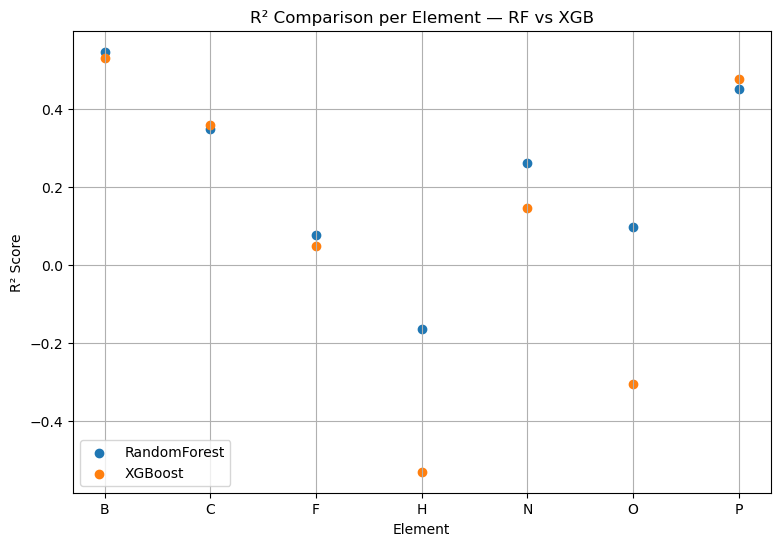

In [8]:
plt.figure(figsize=(9,6))
for m in ["RandomForest","XGBoost"]:
    plt.scatter(res_df[res_df["Model"]==m]["Element"],
                res_df[res_df["Model"]==m]["R2"],label=m)
plt.title("R² Comparison per Element — RF vs XGB")
plt.xlabel("Element")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.show()


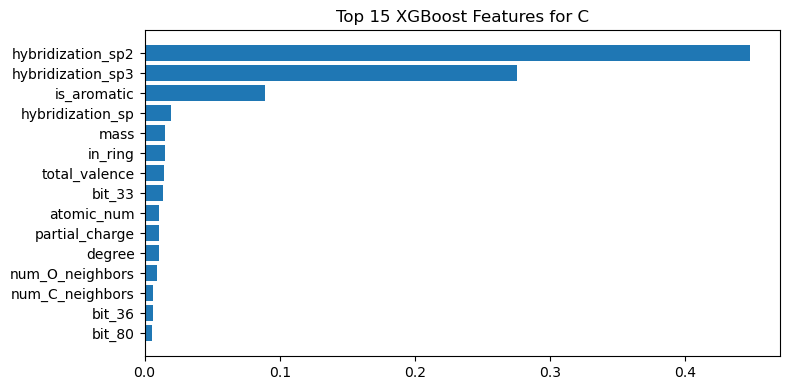

In [9]:
# Example: show for Carbon
elem = "C"
sub = df[df["element_y"]==elem].copy()
X = sub[num_cols].values
y = sub["shift_ppm_y"].values
xgb = XGBRegressor(n_estimators=500,learning_rate=0.05,max_depth=8,
                   subsample=0.8,colsample_bytree=0.8,
                   random_state=42,n_jobs=-1)
xgb.fit(X,y)
importances = xgb.feature_importances_
top_idx = np.argsort(importances)[::-1][:15]
plt.figure(figsize=(8,4))
plt.barh([num_cols[i] for i in top_idx][::-1],
         importances[top_idx][::-1])
plt.title(f"Top 15 XGBoost Features for {elem}")
plt.tight_layout()
plt.show()
